In [1]:
# import libraries
import torch
import numpy as np
from dataloader import get_dataloader_vae
from dataloader import get_dataloader_OOD
from models import get_trained_model
from torch.distributions.multivariate_normal import MultivariateNormal
#from energy import ELOOD
import matplotlib.pyplot as plt

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# class for energy-like ood detection
class ELOOD:
    def __init__(self, model, T=10000):
        self.model = model.to(device)
        
    # get reconstruction term of energy per sample
    def get_recon_energy(self, output, input):
        '''
        # Construct the multivariate Gaussian distribution
        sigma = torch.exp(0.5 * logvar)
        mvn = MultivariateNormal(mu, torch.diag_embed(sigma))

        log_prob = mvn.log_prob(z)

        return -log_prob
        '''
        result = (output - input).pow(2).sum()
        return result


    # get ood scores 
    def get_scores(self, loader):
        ood_scores = []
        for i, (images, _) in enumerate(loader):
            images = images.to(device)
            
            # get reconstructed, mu, logvar, latent space representation
            reconstructed, mu, logvar, z = self.model(images)


            # get reconstruction term of energy
            recon_energy = torch.zeros((images.shape[0]))
            for i in range(images.shape[0]):
                recon_energy[i] = self.get_recon_energy(reconstructed[i], images[i])
            
            kld = torch.zeros((images.shape[0]))
            for i in range(images.shape[0]):
                kld[i] = - 0.5 * (1 + logvar[i] - mu[i].pow(2) - logvar[i].exp()).sum()

            # get KL divergence term of energy
            #kld = -0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim = 1)

            scores = recon_energy.cpu().data.numpy() + kld.cpu().data.numpy()
            
            ood_scores.extend(scores) 
        
        return ood_scores

In [3]:
model = get_trained_model('CIFAR10')
# get dataloaders
train_dl, test_dl = get_dataloader_vae('CIFAR10')
svhn_dl = get_dataloader_OOD('SVHN')
lsun_dl = get_dataloader_OOD('LSUN')
det = ELOOD(model)

Files already downloaded and verified
Using downloaded and verified file: data\test_32x32.mat


In [4]:
print("for c10")
c10 = det.get_scores(train_dl)
print("for svhn")
sv = det.get_scores(svhn_dl)
print("for lsun")
ls = det.get_scores(lsun_dl)

for c10
for svhn
for lsun


In [5]:
len(c10), len(sv), len(ls)

(50000, 26032, 10000)

In [6]:
def statdesc(data):
    ## Statistical Descriptors

    # Mean
    mean = np.mean(data)
    print(f"Mean: {mean}")

    # Median
    median = np.median(data)
    print(f"Median: {median}")

    # Standard Deviation
    std_dev = np.std(data)
    print(f"Standard Deviation: {std_dev}")

    # Quartiles
    quartiles = np.quantile(data, [0.25, 0.5, 0.75])
    print(f"Quartiles: {quartiles}")

    # Interquartile Range (IQR)
    iqr = quartiles[2] - quartiles[0]
    print(f"Interquartile Range (IQR): {iqr}")

    # Minimum and Maximum
    data_min = np.min(data)
    data_max = np.max(data)
    print(f"Minimum: {data_min}")
    print(f"Maximum: {data_max}")

In [7]:
statdesc(c10)
print()
statdesc(sv)
print()
statdesc(ls)

Mean: 1191.624755859375
Median: 1102.68408203125
Standard Deviation: 592.7325439453125
Quartiles: [ 754.78373718 1102.684021   1525.08459473]
Interquartile Range (IQR): 770.3008575439453
Minimum: 64.12699890136719
Maximum: 5435.53564453125

Mean: 750.72509765625
Median: 576.1012573242188
Standard Deviation: 563.7557373046875
Quartiles: [370.43928528 576.10125732 933.4112854 ]
Interquartile Range (IQR): 562.9720001220703
Minimum: 76.08222961425781
Maximum: 4768.61669921875

Mean: 3543.569580078125
Median: 3383.09716796875
Standard Deviation: 1087.8359375
Quartiles: [2737.77319336 3383.09716797 4177.00854492]
Interquartile Range (IQR): 1439.2353515625
Minimum: 1190.0885009765625
Maximum: 8530.6201171875


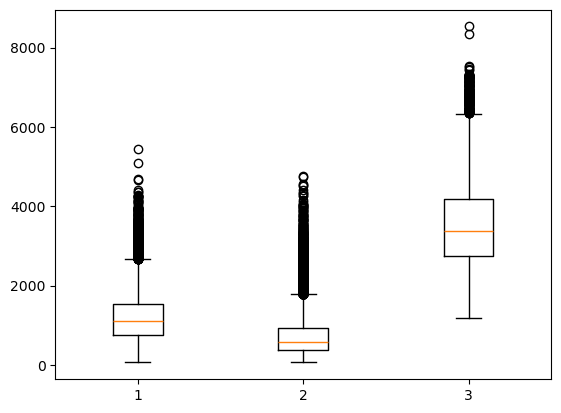

In [8]:
# Plot
plt.boxplot([c10, sv, ls])

# Display the plot
plt.show()